# Отток клиентов

## Подготовка данных

### Изучение файла

В ячейке ниже я буду хранить все импорты проекта в упорядоченом виде в соответствиис рекомендациями PEP-8:

In [1]:
import numpy 

import pandas as pd

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from tqdm import tqdm

Загружаю файл и изучу его:

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.head())

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

На первый взгляд больших проблем в данных нет. Названия столбцов написаны в "верблюжьем регистре", переименовывать столбцы не нужно.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB




**Признаки**

* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**

* `Exited` — факт ухода клиента

#### Вывод

В таблице 13 столбцов с типами данных float64, int64 и object и 10000 строчек. В столбце Tenure 909 явных пропусков, которые необходимо обработать. Тип данных столбца `Tenure` нужно изменить на целочисленный. 

### Предобработка занных

#### Обработка пропусков

In [4]:
print(data['Tenure'].unique())

[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]


In [5]:
data['Tenure'].isna().sum()

909

Обнапужены 909 nan-ов, изучим в данные с этими пропусками, поймем закономерности и подумаем, что с ними делать:

In [6]:
display(data[data['Tenure'].isna()].head(10))

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
30          31    15589475    Azikiwe          591     Spain  Female   39   
48          49    15766205        Yin          550   Germany    Male   38   
51          52    15768193  Trevisani          585   Germany    Male   36   
53          54    15702298   Parkhill          655   Germany    Male   41   
60          61    15651280     Hunter          742   Germany    Male   35   
82          83    15641732      Mills          543    France  Female   36   
85          86    15805254    Ndukaku          652     Spain  Female   75   
94          95    15676966      Capon          730     Spain    Male   42   
99         100    15633059    Fanucci          413    France    Male   34   
111        112    15665790   Rowntree          538   Germany    Male   39   

     Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
30      NaN       0.00              3          1               0   
48      NaN  103391.38              1          0               1   
51      NaN  146050.97              2          0               0   
53      NaN  125561.97              1          0               0   
60      NaN  136857.00              1          0               0   
82      NaN       0.00              2          0               0   
85      NaN       0.00              2          1               1   
94      NaN       0.00              2          0               1   
99      NaN       0.00              2          0               0   
111     NaN  108055.10              2          1               0   

     EstimatedSalary  Exited  
30         140469.38       1  
48          90878.13       0  
51          86424.57       0  
53         164040.94       1  
60          84509.57       0  
82          26019.59       0  
85         114675.75       0  
94          85982.47       0  
99           6534.18       0  
111         27231.26       0

Явной связи этого признака с другими не неблюдается, скорее всего, эти ячейки пропущенны сотрудником при заполнении и пропуск означает то, что человек является клиентом банка менее года. 

<AxesSubplot:>

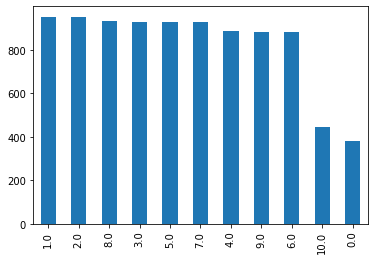

In [7]:
GroupedTenure = data['Tenure'].value_counts()
GroupedTenure.plot(kind='bar')

Клиентов до года меньше всего, когда логично было бы наоборот. Значит, пропущенные ячейки надо заполнить.

<AxesSubplot:>

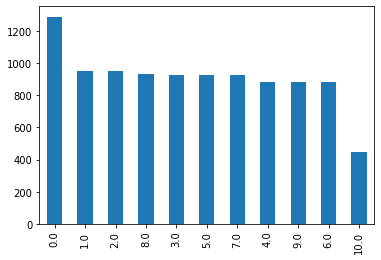

In [8]:
data['Tenure'] = data['Tenure'].fillna(0)
GroupedTenure = data['Tenure'].value_counts()
GroupedTenure.plot(kind='bar')

In [9]:
data['Tenure'].isna().sum()

0

 Пропуски заполнены, соотношение по количеству лет выглядит логичным.

#### Преобразование данных

Изменим типы данных, о которых говорилось в пунке исследования 1.1:

In [10]:
data['Tenure'] = data['Tenure'].astype('int64')

In [11]:
data['Tenure'].dtype

dtype('int64')

In [12]:
display(data['Tenure'].head())

0    2
1    1
2    8
3    1
4    2
Name: Tenure, dtype: int64

Тип данных исправлен c `float` на корректный `int`

#### Поиск дубликатов

Изучим, имеются ли явные дубликаты:

In [13]:
print(data.duplicated().sum())

0


Явных дубликатов не обнаружено.

Попробуем найти неявные дубликаты

In [14]:
print(data['CustomerId'].duplicated().sum())

0


Повторяющихся Id нет.

Признак `RowNumber` не несет для работы с данными никакой смысловлй нагрузки, по сути дублируя индекс строки - его можно удалить.

In [15]:
data = data.drop(['RowNumber'], axis=1)
display(data.head())

CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0

#### Категориальные данные

Изучим есть ли особенности в категориальных признаках:

In [16]:
print(data['Geography'].unique())

['France' 'Spain' 'Germany']


С названиями все хорошо.

In [17]:
print(data['Geography'].value_counts())

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


Клиентов из франции в почти 2 раза больше чем в остальных городах.

In [18]:
print(data['Gender'].unique())

['Female' 'Male']


С полами все впорядке.

In [19]:
print((data['Gender'].value_counts()))

Male      5457
Female    4543
Name: Gender, dtype: int64


Мужчин и женщин примерно поровну, все ок.

#### Количественные данные

In [20]:
print(data['NumOfProducts'].unique())

[1 3 2 4]


In [21]:
print((data['NumOfProducts'].value_counts()))

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64


Клиентов с 1 продуктом больше всего, с 4 - всего 60, выглядит логично.

In [22]:
print(data['HasCrCard'].unique())

[1 0]


In [23]:
print(data['HasCrCard'].value_counts())

1    7055
0    2945
Name: HasCrCard, dtype: int64


Клиентов без кредитных карт сильно меньше, но это не похоже на проблему в данных - люди не любят брать кредиты)

In [24]:
print(data['IsActiveMember'].unique())

[1 0]


In [25]:
print(data['IsActiveMember'].value_counts())

1    5151
0    4849
Name: IsActiveMember, dtype: int64


Активных и пассивных клиентов примерно поровну.

In [26]:
print(data['Exited'].unique())

[1 0]


In [27]:
print(data['Exited'].value_counts())

0    7963
1    2037
Name: Exited, dtype: int64


Ушедших клиентов в 4 раза больше оставшися.

#### Вывод:

Пропуски признака `Tenure` заполнены нулями. Тип данных столбца изменен на целочисленный. Столбец `RowNumber` удален, как дублирующий индексацию. В остальных данных проблем не обнаружено.

## Исследование задачи

### Мультиколлинеарность признаков

Изучу, есть ли в данных мультиколлинеарность. Высокая корреляция (мультиколлениарность) может привести к нестабильной работе моделей машинного обучения: наличие «лишних» признаков ведёт к переобучению или вовсе ломает модель. Использую метод sns.pairplot с параметром hue='is_ultra', чтобы исследовать, имеется ли корреляция независимых переменных:

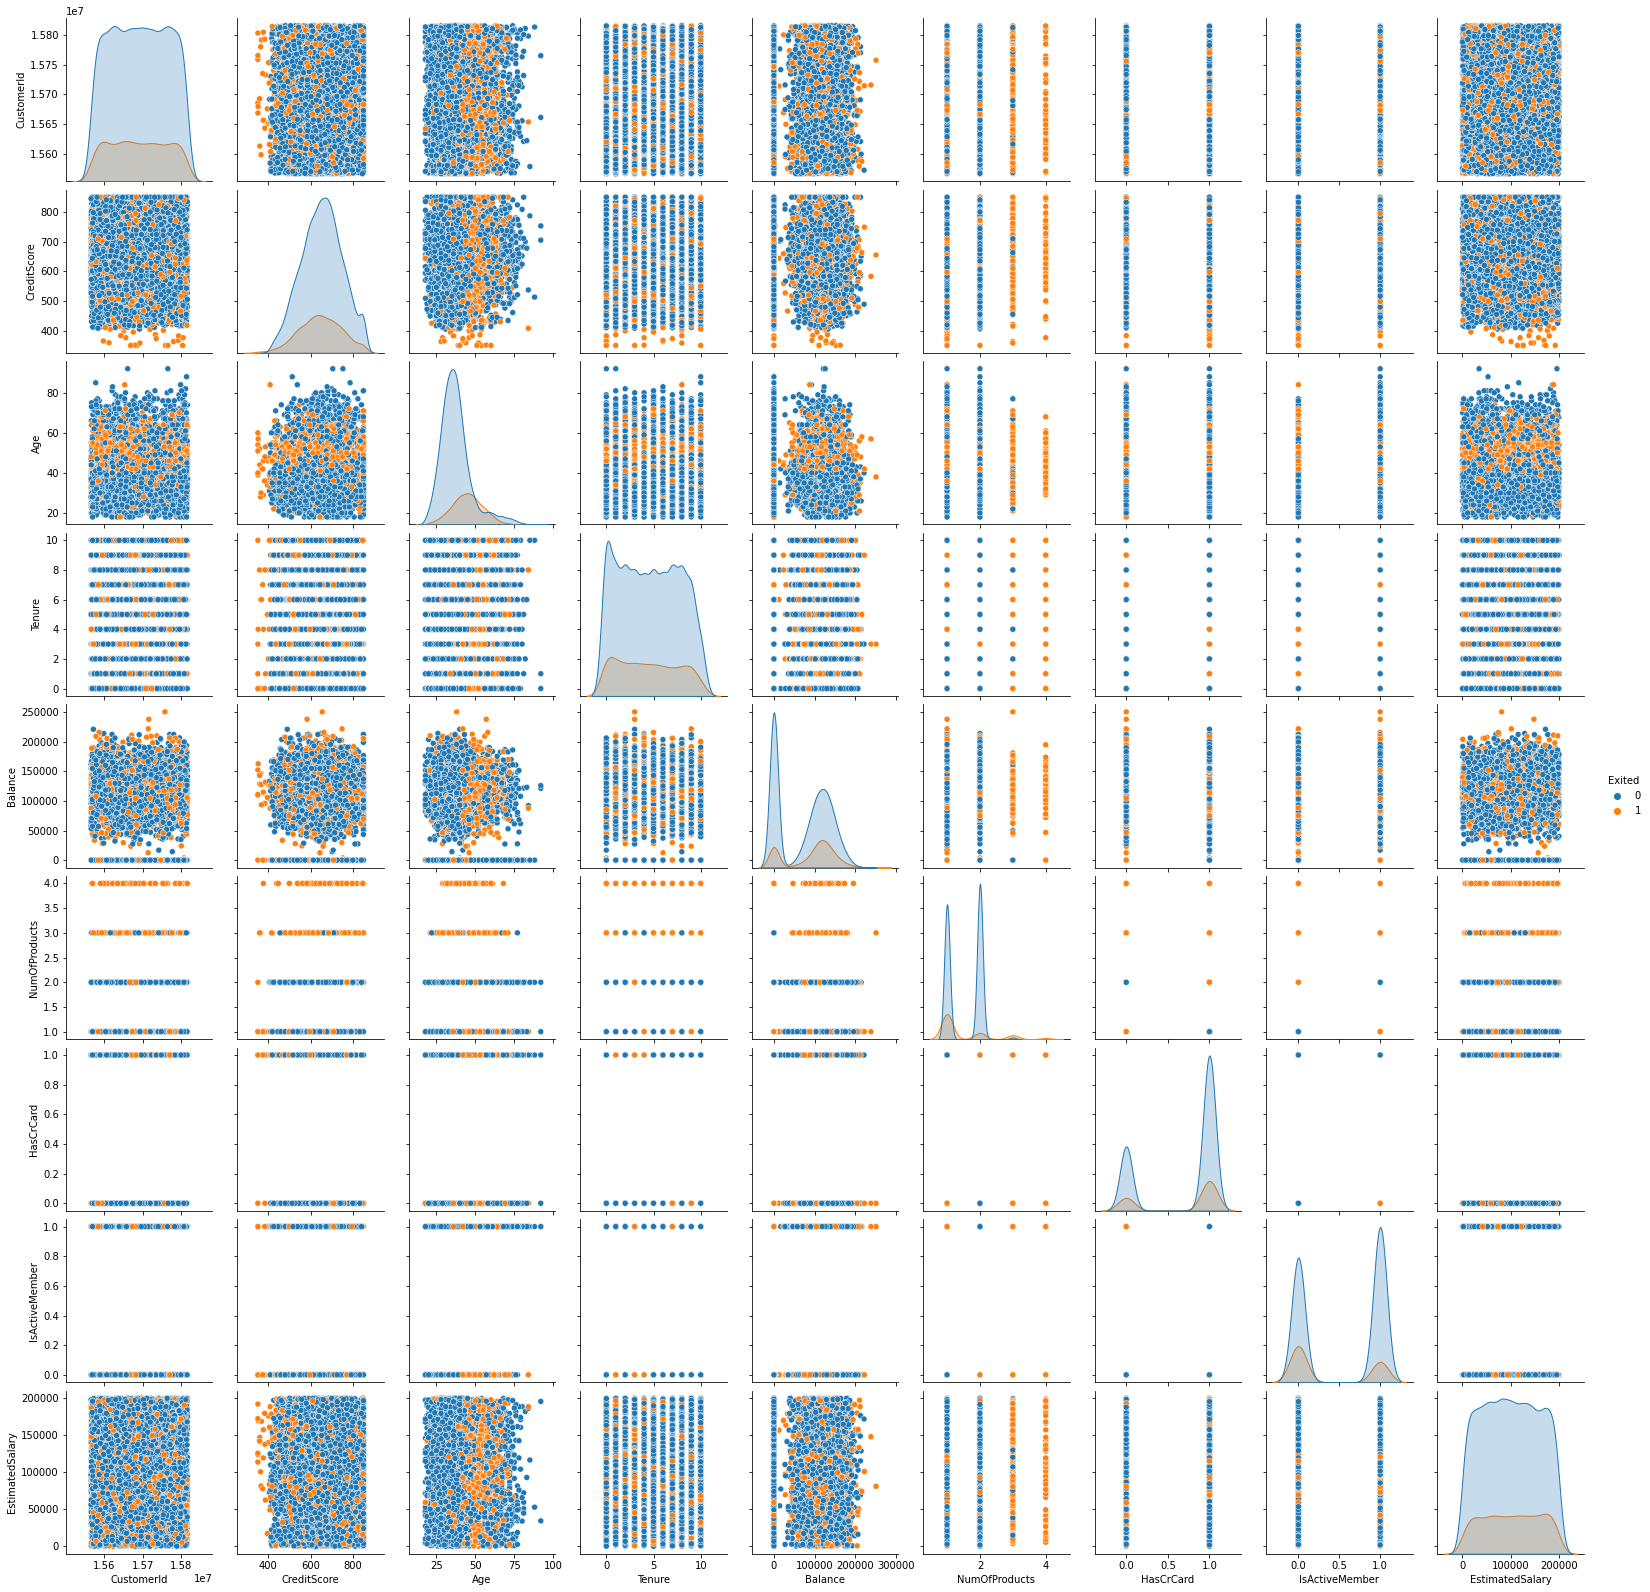

In [28]:
sns.pairplot(data, hue='Exited')

Корелляций данных не обнаружено, в качестве фичей можно передавать все стоблцы.

### Дамми-преобразование

Теперь можно обучить первую пробную модель.
Чтобы предсказать класс, обратимся к логистической регрессии. Логистическая регрессия подходит для задачи классификации, как у нас, когда выбор между двумя категориями — ушел клиент из банка или нет.

Данные содержат категориальные признаки, чтобы обучить модель их нужно преобразовать в численные с помощью техники прямого кодирования, или отображения (One-Hot Encoding или OHE).

Преобразую категориальные колонки техникой OHE: 

In [29]:
display(data.head())

CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0

In [30]:
data_ohe = pd.get_dummies(data, drop_first=True, columns=['Geography', 'Gender']) 
display(data_ohe.head())

CustomerId   Surname  CreditScore  Age  Tenure    Balance  NumOfProducts  \
0    15634602  Hargrave          619   42       2       0.00              1   
1    15647311      Hill          608   41       1   83807.86              1   
2    15619304      Onio          502   42       8  159660.80              3   
3    15701354      Boni          699   39       1       0.00              2   
4    15737888  Mitchell          850   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0          1               1        101348.88       1                  0   
1          0               1        112542.58       0                  0   
2          1               0        113931.57       1                  0   
3          0               0         93826.63       0                  0   
4          1               1         79084.10       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            0

In [31]:
df_to_split_again, df_test = train_test_split(data_ohe, test_size=0.2, random_state=12345)
train, valid = train_test_split(df_to_split_again, test_size=0.25, random_state=12345)

features_train = train.drop(['Exited', 'Surname', 'CustomerId'], axis=1)
target_train = train['Exited']
features_valid = valid.drop(['Exited', 'Surname', 'CustomerId'], axis=1)
target_valid = valid['Exited']
features_test = df_test.drop(['Exited', 'Surname', 'CustomerId'], axis=1)
target_test = df_test['Exited']

model_LinearR_unnormalized = LogisticRegression(solver='liblinear', random_state=12345)
model_LinearR_unnormalized.fit(features_train, target_train)
print("Обучено!")



Обучено!


Я обучила первую модель по логике примера в теоретическом курсе, но это не особо осмысленно, т.к. данные пока не масштабированы.

In [32]:
predicted_valid = model_LinearR_unnormalized.predict(features_valid)
print('Метрика качества для модели логичстической регрессии на сырых данных:', accuracy_score(target_valid, predicted_valid))

Метрика качества для модели логичстической регрессии на сырых данных: 0.7995


### Масштабирование признаков

В данных есть столбцы с разбросами в одном столбце больше и меньше в другом. Алгоритм автоматически решит, что один признак важнее другого. А это не так: все признаки значимы. Для этого стандартизирую данные.

Создадим объект этой структуры и настроим его на обучающих данных. Настройка — это вычисление среднего и дисперсии:

In [33]:
display(features_train.head())

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
492           639   38       4   81550.94              2          0   
6655          554   44       0   85304.27              1          1   
4287          714   53       1   99141.86              1          1   
42            556   61       2  117419.35              1          1   
8178          707   46       7  127476.73              2          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
492                1        118974.77                  0                0   
6655               1         58076.52                  0                0   
4287               1         72496.05                  1                0   
42                 1         94153.83                  0                0   
8178               1        146011.55                  0                0   

      Gender_Male  
492             0  
6655            1  
4287            1  
42              0  
8178            0

Преобразуем обучающую, валидационную и тестовую выборки функцией transform()

In [34]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [35]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [36]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [37]:
print(type(features_train))

<class 'pandas.core.frame.DataFrame'>


In [38]:
display(features_train.head())

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
492     -0.134048 -0.078068 -0.174142  0.076163       0.816929          0   
6655    -1.010798  0.494555 -1.451074  0.136391      -0.896909          1   
4287     0.639554  1.353490 -1.131841  0.358435      -0.896909          1   
42      -0.990168  2.116987 -0.812608  0.651725      -0.896909          1   
8178     0.567351  0.685430  0.783558  0.813110       0.816929          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
492                1         0.331571                  0                0   
6655               1        -0.727858                  0                0   
4287               1        -0.477006                  1                0   
42                 1        -0.100232                  0                0   
8178               1         0.801922                  0                0   

      Gender_Male  
492             0  
6655            1  
4287            1  
42              0  
8178            0

Данные масштабированы.

### Исследование баланса классов

#### Проверка адекватности модели

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0».

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

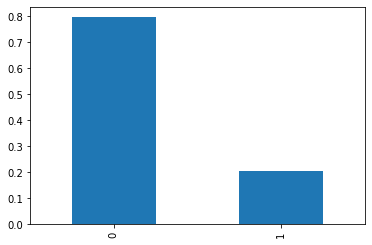

In [39]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Дисбаланс существенный: 4 к 1. 

Сравним качество модели дерева решений  до устранения дисбаланса с качеством константной модели

In [40]:
DecisionTree_model_disbalanced = DecisionTreeClassifier(random_state=12345)
DecisionTree_model_disbalanced.fit(features_train, target_train)
predicted_valid = DecisionTree_model_disbalanced.predict(features_valid)

In [41]:
accuracy_DecisionTree_disbalanced = accuracy_score(target_valid, predicted_valid)
print('Качество модели дерева решений с дисбалнсом:', accuracy_DecisionTree_disbalanced)

Качество модели дерева решений с дисбалнсом: 0.791


In [42]:
target_pred_constant = pd.Series(numpy.zeros(target_valid.shape).astype(int))
accuracy_const = accuracy_score(target_valid, target_pred_constant)
print('Качество константной модели:', accuracy_const)

Качество константной модели: 0.8045


Вывод: accuracy решающего дерева и константной модели почти одинаковы, с этим работать нельзя. Accuracy не подходит. Нужна новая метрика.

#### Матрица ошибок

Рассчитаю матрицу ошибок функцией confusion_matrix(), матрица ошибок поможет построить новые метрики.

In [43]:
print(confusion_matrix(target_valid, predicted_valid))

[[1386  223]
 [ 195  196]]


Правильные прогнозы:
* TN (Истинно отрицательные ответы) в левом верхнем углу - 1386 клиентов действительно остались, как и предсказала модель;
* TP (Истинно положительные ответы) в правом нижнем углу - 196 клиентов ушли, и модель предсказала также.

Ошибочные варианты:
* FP (Ложно положительные ответы)  в правом верхнем углу  - Модель предсказала, что 223 клиента ушли, а они остались;
* FN (Ложно отрицательные ответы) в левом нижнем углу. - 195 клиентов остались по мнению модели, тогда как они на самом деле ушли. 

In [44]:
print("Доля правильных ответов, найденных моделью:", recall_score(target_valid, predicted_valid))

Доля правильных ответов, найденных моделью: 0.5012787723785166


Полнота очень плохая, посмотрим на точность - как много отрицательных ответов нашла модель, пока искала положительные.

In [45]:
print(precision_score(target_valid, predicted_valid))

0.4677804295942721


Точность еще хуже...

Модель плохо предсказывает положительные классы - значит, что мала как точность, так и полнота. 
Если положительный класс плохо прогнозируется по одной из шкал (Recall или Precision), то близкая к нулю F1-мера покажет, что прогноз класса 1 не удался:

In [46]:
print(f1_score(target_valid, predicted_valid))

0.4839506172839506


### Вывод:

Я исследовала признаки на наличие мультиколлинеарности, преобразовала категориальные данные методом OHE, чтобы обучить модели и масштабировала признаки, чтобы модель учитывала важность каждого в равной степени. После этого исследовала баланс классов, выявила существенный дисбаланс и попробовала обучить пробную модель на дисбалансированных данных. В итоге точность плохая по всем метрикам, нужно устранять дисбаланс классов.

## Борьба с дисбалансом

Придадим объектам редкого класса больший вес. У нас это клас "1" целевого признака.

### Балансировка классов

Обучу модель Логистической регрессии на несбалансированных данных, чтобы посмотреть, как изменится метрика после балансировки:

In [47]:
model_LogisticR_disbalanced = LogisticRegression(random_state=12345, solver='liblinear')
model_LogisticR_disbalanced.fit(features_train, target_train)
predicted_valid = model_LogisticR_disbalanced.predict(features_valid)
print("F1 несбалансированной модели логистической регрессии:", f1_score(target_valid, predicted_valid)) 

F1 несбалансированной модели логистической регрессии: 0.3056603773584906


In [48]:
model_LogisticR = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_LogisticR.fit(features_train, target_train)
predicted_valid = model_LogisticR.predict(features_valid)
print("F1 сбалансированной модели логистической регрессии:", f1_score(target_valid, predicted_valid)) 

F1 сбалансированной модели логистической регрессии: 0.47763864042933807


Чуть лучше, но качество по-прежнему низкое. Попробуем увеличить выборку.

### Увеличение выборки для '1' класса

Разделю обучающую выборку на отрицательные и положительные объекты:

* features_zeros — признаки объектов с ответом «0»;
* features_ones — признаки объектов с ответом «1»;
* target_zeros — целевой признак объектов, у которых ответы только «0»;
* target_ones — целевой признак объектов, у которых ответы только «1».

In [49]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_ones = target_train[target_train == 1]
target_zeros = target_train[target_train == 0]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4781, 11)
(1219, 11)
(4781,)
(1219,)


Продублирую объекты положительного класса и объединю их с объектами отрицательного класса:

In [50]:
repeat = 5 # Число повторений
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

print(features_upsampled.shape)
print(target_upsampled.shape)

(10876, 11)
(10876,)


In [51]:
display(features_upsampled.head())
display(target_upsampled.head())

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
492     -0.134048 -0.078068 -0.174142  0.076163       0.816929          0   
6655    -1.010798  0.494555 -1.451074  0.136391      -0.896909          1   
42      -0.990168  2.116987 -0.812608  0.651725      -0.896909          1   
8178     0.567351  0.685430  0.783558  0.813110       0.816929          1   
2127     0.598296 -0.459816  1.422024  0.921963       0.816929          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
492                1         0.331571                  0                0   
6655               1        -0.727858                  0                0   
42                 1        -0.100232                  0                0   
8178               1         0.801922                  0                0   
2127               0         0.820416                  1                0   

      Gender_Male  
492             0  
6655            1  
42              0  
8178            0  
2127            1

492     0
6655    0
42      0
8178    0
2127    0
Name: Exited, dtype: int64

Перемешаем данные: идущие друг за другом одинаковые данные не помогут обучению.

In [52]:
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

In [53]:
display(features_upsampled.head())
display(target_upsampled.head())

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
4023    -1.206777 -0.078068  1.102791  0.147267      -0.896909          1   
6390    -0.804504 -0.173505  0.783558 -1.232442       0.816929          1   
6104     0.866478  1.067178  1.422024  0.633908      -0.896909          1   
380     -1.743141  1.067178  1.422024 -1.232442       0.816929          1   
4270    -0.299083  1.735239  0.783558 -0.085411       0.816929          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
4023               0        -1.577481                  0                0   
6390               0        -1.176941                  0                1   
6104               0         1.486462                  1                0   
380                1         0.193188                  0                0   
4270               1        -0.269545                  0                0   

      Gender_Male  
4023            1  
6390            0  
6104            1  
380             0  
4270            0

4023    0
6390    0
6104    1
380     0
4270    0
Name: Exited, dtype: int64

Данные перемешаны.

### Обучение моделей на новых данных

#### Логистическая регрессия

Теперь обучу на новых данных модель LogisticRegression и найду для неё значение F1-меры:

In [54]:
model_LogisticR_upsampled = LogisticRegression(random_state=12345, solver='liblinear')
model_LogisticR_upsampled.fit(features_upsampled, target_upsampled)
predicted_valid = model_LogisticR_upsampled.predict(features_valid)

print('F1 метрика для модели логистической регресии с увеличенной выборкой:', f1_score(target_valid, predicted_valid))

F1 метрика для модели логистической регресии с увеличенной выборкой: 0.4666666666666666


Вычислю метрику AUC-ROC (площадь под кривой ошибок):

In [55]:
print("AUC ROC метрика для модели логистической регресии с увеличенной выборкой:", roc_auc_score(target_valid, predicted_valid))

AUC ROC метрика для модели логистической регресии с увеличенной выборкой: 0.6990807780404026


Нет разницы с метрикой до увеличения выборки положительного класса, попробую уменьшить отрицательный класс:

In [56]:
features_downsampled = pd.concat([features_zeros.sample(frac=0.2, random_state=12345)] + [features_ones])
target_downsampled = pd.concat([target_zeros.sample(frac=0.2, random_state=12345)] + [target_ones])
    
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

model_LogisticR_downsampled = LogisticRegression(random_state=12345, solver='liblinear')
model_LogisticR_downsampled.fit(features_downsampled, target_downsampled)
predicted_valid = model_LogisticR_downsampled.predict(features_valid)

print("F1 метрика для модели логистической регресии с уменьшением выборки:", f1_score(target_valid, predicted_valid))

F1 метрика для модели логистической регресии с уменьшением выборки: 0.4675925925925926


Метрика F1 понемногу растет, но все еще очень далека от 0.59.

In [57]:
print("AUC ROC метрика для модели логистической регресии с уменьшением выборки:", roc_auc_score(target_valid, predicted_valid))

AUC ROC метрика для модели логистической регресии с уменьшением выборки: 0.7003953147178832


Логистическая регрессия вычисляет, к какому классу близок объект, затем сравнивает результат с нулём. Для удобства близость к классам переведём в вероятность классов: модель попытается оценить, насколько вероятен тот или иной класс. Изменим значение порога и посмотрим, какими станут метрики.

Найдем значения вероятностей классов для моделей обученных на увеличенной и уменьшенной выборках: 

In [58]:
probabilities_upsampled= model_LogisticR_upsampled.predict_proba(features_valid) 
probabilities_one_upsampled = probabilities_upsampled[:, 1]
print(pd.DataFrame(probabilities_upsampled).head())

          0         1
0  0.587975  0.412025
1  0.341371  0.658629
2  0.691789  0.308211
3  0.133460  0.866540
4  0.152216  0.847784


Строки соответствуют объектам. В первом столбце указана вероятность отрицательного класса, а во втором — положительного.

In [59]:
for threshold in numpy.arange(0, 1, 0.05):
    predicted_valid = model_LogisticR_upsampled.predict_proba(features_valid)
    predicted_valid = probabilities_one_upsampled > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.196, Полнота = 1.000
Порог = 0.05 | Точность = 0.196, Полнота = 1.000
Порог = 0.10 | Точность = 0.196, Полнота = 0.997
Порог = 0.15 | Точность = 0.202, Полнота = 0.990
Порог = 0.20 | Точность = 0.214, Полнота = 0.987
Порог = 0.25 | Точность = 0.228, Полнота = 0.967
Порог = 0.30 | Точность = 0.244, Полнота = 0.954
Порог = 0.35 | Точность = 0.265, Полнота = 0.931
Порог = 0.40 | Точность = 0.285, Полнота = 0.893
Порог = 0.45 | Точность = 0.307, Полнота = 0.829
Порог = 0.50 | Точность = 0.335, Полнота = 0.770
Порог = 0.55 | Точность = 0.361, Полнота = 0.701
Порог = 0.60 | Точность = 0.394, Полнота = 0.627
Порог = 0.65 | Точность = 0.428, Полнота = 0.542
Порог = 0.70 | Точность = 0.496, Полнота = 0.491
Порог = 0.75 | Точность = 0.518, Полнота = 0.399
Порог = 0.80 | Точность = 0.528, Полнота = 0.294
Порог = 0.85 | Точность = 0.575, Полнота = 0.176
Порог = 0.90 | Точность = 0.553, Полнота = 0.066
Порог = 0.95 | Точность = 0.571, Полнота = 0.010


При увеличении порога точность растет до середины, полнота падает до нуля.

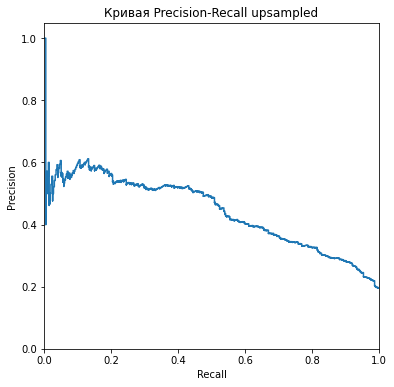

In [60]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_upsampled)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall upsampled')
plt.show() 

In [61]:
probabilities_downsampled= model_LogisticR_downsampled.predict_proba(features_valid) 
probabilities_one_downsampled = probabilities_downsampled[:, 1]

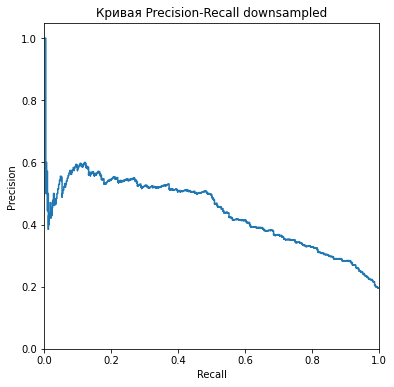

In [62]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_downsampled)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall downsampled')
plt.show() 

In [63]:
model_LogisticR_class_weight = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_LogisticR_class_weight.fit(features_train, target_train)
predicted_valid = model_LogisticR_class_weight.predict(features_valid)

print('F1 метрика для модели логистической регресии со взвешенными классами:', f1_score(target_valid, predicted_valid))
print("AUC ROC метрика для модели логистической регрессии со взвешенными классами:", roc_auc_score(target_valid, predicted_valid))

F1 метрика для модели логистической регресии со взвешенными классами: 0.47763864042933807
AUC ROC метрика для модели логистической регрессии со взвешенными классами: 0.6984862959153992


#### Дерево решений

Изучим другие модели и метрику f1 на них:

In [64]:
DecisionTree_model_upsampled = DecisionTreeClassifier(random_state=12345)
DecisionTree_model_upsampled.fit(features_upsampled, target_upsampled)
predicted_valid = DecisionTree_model_upsampled.predict(features_valid)

print('F1 метрика для модели дерева решений с увеличенной выборкой:', f1_score(target_valid, predicted_valid))
print("AUC ROC метрика для модели дерева решений с увеличенной выборкой:", roc_auc_score(target_valid, predicted_valid))

F1 метрика для модели дерева решений с увеличенной выборкой: 0.4547803617571059
AUC ROC метрика для модели дерева решений с увеличенной выборкой: 0.6607382705020831


In [65]:
DecisionTree_model_downsampled = DecisionTreeClassifier(random_state=12345)
DecisionTree_model_downsampled.fit(features_downsampled, target_downsampled)
predicted_valid = DecisionTree_model_downsampled.predict(features_valid)

print('F1 метрика для модели дерева решений с уменьшенной выборкой:', f1_score(target_valid, predicted_valid))
print("AUC ROC метрика для модели дерева решений с уменьшенной выборкой:", roc_auc_score(target_valid, predicted_valid))

F1 метрика для модели дерева решений с уменьшенной выборкой: 0.4650040225261464
AUC ROC метрика для модели дерева решений с уменьшенной выборкой: 0.6946118301942875


In [66]:
DecisionTree_model_class_weigh = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
DecisionTree_model_class_weigh.fit(features_train, target_train)
predicted_valid = DecisionTree_model_class_weigh.predict(features_valid)

print('F1 метрика для модели дерева решений с уменьшенной выборкой:', f1_score(target_valid, predicted_valid))
print("AUC ROC метрика для модели дерева решений с уменьшенной выборкой:", roc_auc_score(target_valid, predicted_valid))

F1 метрика для модели дерева решений с уменьшенной выборкой: 0.4538258575197889
AUC ROC метрика для модели дерева решений с уменьшенной выборкой: 0.6593522052266741


#### Случайный лес

In [74]:
best_result_f1 = 0
best_result_auc_roc = 0
best_est_f1 = 0
best_est_auc_roc = 0
best_model_f1 = 0
best_model_auc_roc = 0
best_depth_auc_roc = 0
best_depth_f1 = 0 

for depth in tqdm(range(2, 22, 2)):
    for est in range(50, 351, 50):
        RandomForest_model_upsampled = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # задаю гиперпараметры модели с количеством деревьев = est
        RandomForest_model_upsampled.fit(features_upsampled, target_upsampled) # обучаю модель на тренировочной выборке
        predicted_valid = RandomForest_model_upsampled.predict(features_valid)
        result_f1 = f1_score(target_valid, predicted_valid) # считаю метрику F1 на валидационной выборке
        result_auc_roc = roc_auc_score(target_valid, predicted_valid) # считаю метрику ACU ROC на валидационной выборке

        if result_f1 > best_result_f1:
            best_result_f1 = result_f1 # сохраняю лучшую метрику качества на валидационной выборке
            best_est_f1 = est # сохраняю соответствующее количество деревьев
            best_model_f1 = RandomForest_model_upsampled
            best_depth_f1 = depth

        if  result_auc_roc > best_result_auc_roc:
            best_result_auc_roc = result_auc_roc # сохраняю лучшую метрику на валидационной выборке
            best_est_auc_roc = est # сохраняю соответствующее количество деревьев
            best_model_auc_roc = RandomForest_model_upsampled
            best_depth_auc_roc = depth
print("F1 наилучшей модели случайного леса на увеличенной выборке:", best_result_f1, 'количество деревьев:', best_est_f1, 'глубина:', best_depth_f1)
print("AUC ROC наилучшей модели случайного леса на увеличенной выборке:", best_result_auc_roc, 'количество деревьев:', best_est_auc_roc, 'глубина:', best_depth_auc_roc)

100%|██████████| 10/10 [01:59<00:00, 11.91s/it]

F1 наилучшей модели случайного леса на увеличенной выборке: 0.5931034482758621 количество деревьев: 350 губина: 20
AUC ROC наилучшей модели случайного леса на увеличенной выборке: 0.768105875041129 количество деревьев: 50 губина: 10


In [75]:
best_result_f1 = 0
best_result_auc_roc = 0
best_est_f1 = 0
best_est_auc_roc = 0
best_model_f1 = 0
best_model_auc_roc = 0
best_depth_f1 = 0 
best_depth_auc_roc = 0

for depth in tqdm(range(2, 22, 2)):
    for est in range(50, 351, 50):
        RandomForest_model_downsampled = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est) # задаю гиперпараметры модели с количеством деревьев = est
        RandomForest_model_downsampled.fit(features_downsampled, target_downsampled) # обучаю модель на тренировочной выборке
        predicted_valid = RandomForest_model_downsampled.predict(features_valid)
        result_f1 = f1_score(target_valid, predicted_valid) # считаю метрику F1 на валидационной выборке
        result_auc_roc = roc_auc_score(target_valid, predicted_valid) # считаю метрику ACU ROC на валидационной выборке
        if result_f1 > best_result_f1:
            best_result_f1 = result_f1 # сохраняю лучшую метрику качества на валидационной выборке
            best_est = est # сохраняю соответствующее количество деревьев
            best_model = RandomForest_model_downsampled
        if  result_auc_roc > best_result_auc_roc:
            best_result_auc_roc = result_auc_roc # сохраняю лучшую метрику качества на валидационной выборке
            best_est = est # сохраняю соответствующее количество деревьев
            best_model = RandomForest_model_downsampled
print("F1 наилучшей модели случайного леса на уменьшенной выборке:", best_result_f1)
print("AUC ROC наилучшей модели случайного леса на уменьшенной выборке:", best_result_auc_roc)

100%|██████████| 10/10 [00:42<00:00,  4.29s/it]

F1 наилучшей модели случайного леса на уменьшенной выборке: 0.5531914893617021
AUC ROC наилучшей модели случайного леса на уменьшенной выборке: 0.7678507563751849


In [76]:
best_result_f1 = 0
best_result_auc_roc = 0
best_est_f1 = 0
best_est_auc_roc = 0
best_model_f1 = 0
best_model_auc_roc = 0
best_depth_f1 = 0 
best_depth_auc_roc = 0

for depth in tqdm(range(2, 22, 2)):
    for est in range(50, 351, 50):
        RandomForest_model_class_weight = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') # задаю гиперпараметры модели с количеством деревьев = est
        RandomForest_model_class_weight.fit(features_train, target_train) # обучаю модель на тренировочной выборке
        predicted_valid = RandomForest_model_class_weight.predict(features_valid)
        result_f1 = f1_score(target_valid, predicted_valid) # считаю метрику F1 на валидационной выборке
        result_auc_roc = roc_auc_score(target_valid, predicted_valid) # считаю метрику ACU ROC на валидационной выборке

        if result_f1 > best_result_f1:
            best_result_f1 = result_f1 # сохраняю лучшую метрику качества на валидационной выборке
            best_est_f1 = est # сохраняю соответствующее количество деревьев
            best_model_f1 = RandomForest_model_class_weight
            best_depth_f1 = depth

        if  result_auc_roc > best_result_auc_roc:
            best_result_auc_roc = result_auc_roc # сохраняю лучшую метрику на валидационной выборке
            best_est_auc_roc = est # сохраняю соответствующее количество деревьев
            best_model_auc_roc = RandomForest_model_class_weight
            best_depth_auc_roc = depth
print("F1 наилучшей модели случайного леса со взвешенными классами:", best_result_f1, 'количество деревьев:', best_est_f1, 'глубина:', best_depth_f1)
print("AUC ROC наилучшей модели случайного леса со взвешенными классами:", best_result_auc_roc, 'количество деревьев:', best_est_auc_roc, 'глубина:', best_depth_auc_roc)

100%|██████████| 10/10 [01:20<00:00,  8.02s/it]

F1 наилучшей модели случайного леса со взвешенными классами: 0.5989847715736041 количество деревьев: 150 губина: 10
AUC ROC наилучшей модели случайного леса со взвешенными классами: 0.7612113129630483 количество деревьев: 300 губина: 8


#### Вывод:

Наилучшая метрика F1 = 0.59 достигнута на модели случайного леса cо взвешенными классами, также этого порога достигла эта модель, обученная на увеличенной выборке.

## Тестирование модели

In [77]:
predicted_test = RandomForest_model_class_weight.predict(features_test)
result = f1_score(target_test, predicted_test) # считаю качество модели на тестовой выборке

print("Качество наилучшей модели случайного леса на тестовой выборке:", result)

Качество наилучшей модели случайного леса на тестовой выборке: 0.5413533834586466


In [78]:
model = RandomForest_model_upsampled
predicted_test = model.predict(features_test)
result = f1_score(target_test, predicted_test) # считаю качество модели на тестовой выборке

print("Качество наилучшей модели случайного леса при увеличенном датасете на тестовой выборке:", result)

Качество наилучшей модели случайного леса при увеличенном датасете на тестовой выборке: 0.6007802340702211


Построим ROC-кривую для модели случайного леса, чтобы проверить на адекватность:

In [79]:
fpr, tpr, thresholds = roc_curve(target_test, predicted_test) 

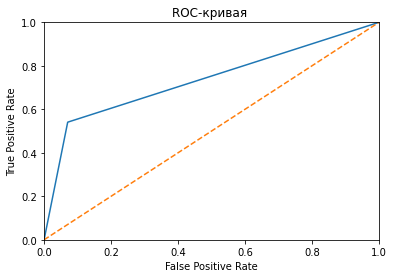

In [80]:
plt.figure()

plt.plot(fpr, tpr) # график

plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели

plt.xlim([0.0, 1.0]) # границы оси x от 0 до 1 
plt.ylim([0.0, 1.0]) # границы оси y от 0 до 1 

plt.xlabel('False Positive Rate') # подписи осей
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая ') # заголовок
plt.show()

По горизонтали доля ложноположительных ответов (FPR), а по вертикали — доля истинно положительных ответов (TPR)

### Вывод:

При обучении модели RandomForest_model_upsampled (случайный лес обученный на увеличенной выборке) достигнуто значение метрики f1 = 0.59 на валидационной выборке, и f1 = 0.6 на тестовой. Модель готова!

Модель отличается от константной.

## Summary

Были подготовлены и исследованы данные о поведении клиентов банка «Бета-Банк» по проблеме увеличения оттока клиентов.
Заполнены пропуски данных, изменен некорректный формат одного столбца.
Исследован баланс классов, обучены три модели классификации: логистическая регрессия, дерево решений и случайный лес без учёта дисбаланса.
Далее был учитен дисбаланс классов и переобучены вышеназванные модели.
Наилучшая метрика F1 = 0.6 достигнута на тестовой выборке у модели случайного леса (обученной на увеличенной выборке). 